# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors
from functools import partial

from IPython.display import clear_output
from ocp import *
from costs import *
from ocp_sys import *
import pdb

from scipy.optimize import fmin
import crocoddyl

import casadi
from casadi import mtimes, MX, sin, cos, vertcat, horzcat, sum1, cross, Function, jacobian, solve

np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

## Define Noise

In [2]:
i = 1
sigma = 0.1
noise_i = np.random.randn(50000)*sigma
noise = np.zeros((50000, 6))
noise[:,i] = noise_i

## Part 1: Standard Controller 

#### Try solving and analyse result

In [3]:
biped = Biped_Casadi()
biped.def_compute_matrices()

COT: 2060.90, Dist: 0.327, dT: 0.376


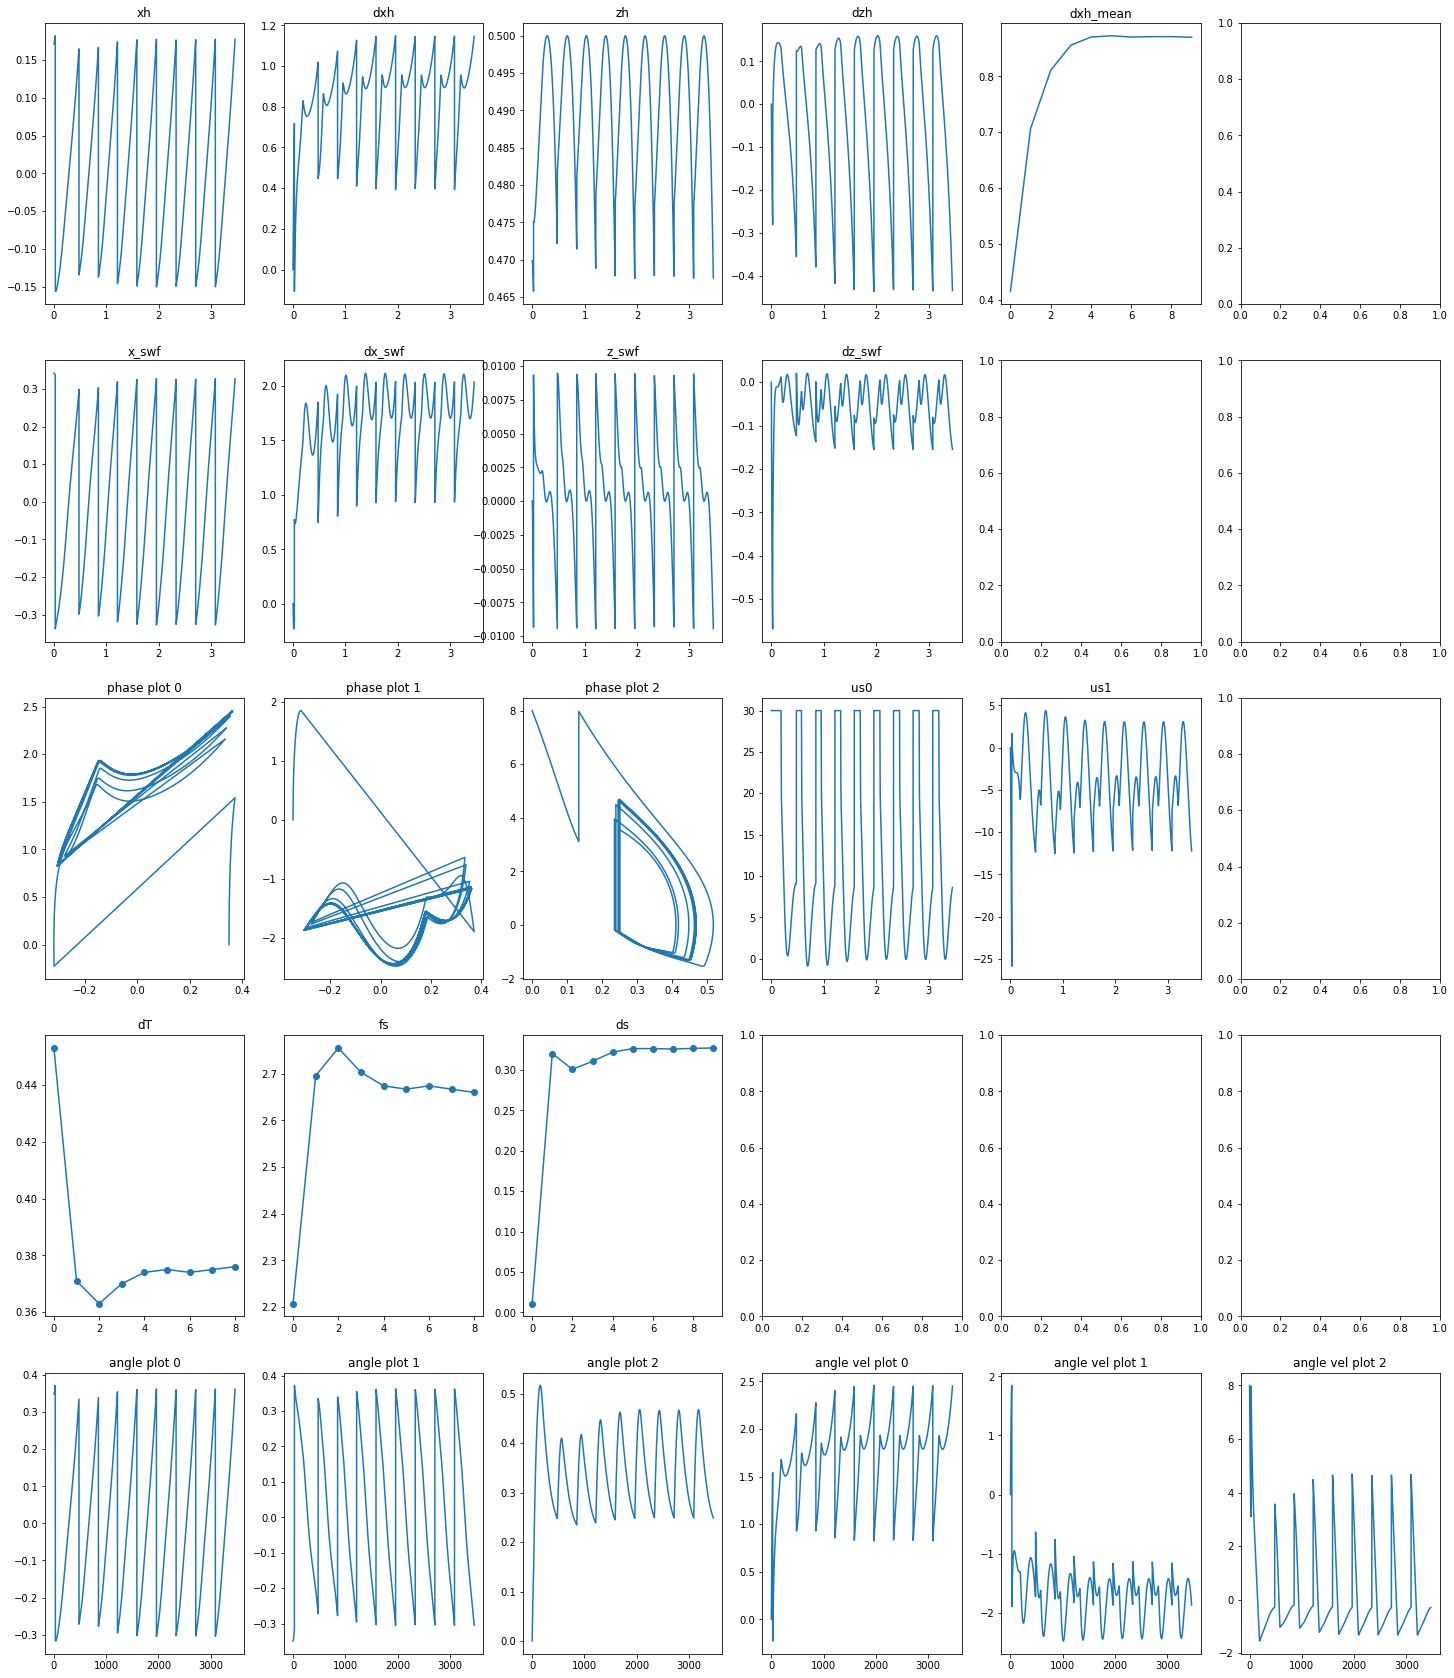

In [4]:
#standard values with standard params
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

#standard values with already stable limit cycle
#q0, dq0 = (np.array([-0.3035,  0.3608,  0.2487]), np.array([ 0.8319, -1.1396,  4.6439]))
# qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
# T = int(0.375/biped.dT)

sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)
#clear_output()

%matplotlib qt
#biped.animate(sln, dt = 0.001)

%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, to_plot=True)

xs_std, us_std = np.hstack([res['qs'], res['dqs']]), res['us']
ddqs_std = np.array(np.gradient(xs_std, axis=0))[:,3:]/biped.dT

#### Try optimizing

In [5]:
def opt_func(opt_parameters, num_steps):
    print(num_steps)
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    control_params = opt_parameters[6:]

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, control_params);
    results = biped.analyse(sln, control_params, False)

    # calculate metrics 
    distance = np.sum(results['ds'])
    frequency = (results['fs'][-1])
    last_velocity = results['last_mean_velocity']
    ave_velocity = results['total_mean_velocity']
    CoT = results['cot']
    step_length = (results['ds'])[-1]

    w1, w2, vd, sd = 10, 1e-3, .8, 0.4 
    
    velocity = last_velocity
    objective_value = w1*abs(vd - velocity) + w2*CoT 
    #objective_value = w1*abs(sd - step_length) + w2*CoT #- 0.3*distance
    #objective_value = w1*abs(sd - step_length) + w2*CoT #- 0.3*distance

    if distance < 0 or CoT < 0 or velocity < 0:
        objective_value = 1000        

    print('Obj:{}, vel:{}, step length:{}:'.format(objective_value, velocity, step_length))
    print('Params', opt_parameters)
    return objective_value

In [7]:
#optimize
biped.set_control()
opt_parameters0 = np.concatenate([q0, dq0, biped.control_parameters])

In [8]:
opt_params = np.array([  0.3378,  -0.3795,  -0.0001,   0.    ,   0.0002,   7.7201,
       477.4578, 174.514 ,  73.1452,   5.5947,   0.138 ])

#### Observe the result

COT: 828.22, Dist: 0.310, dT: 0.382


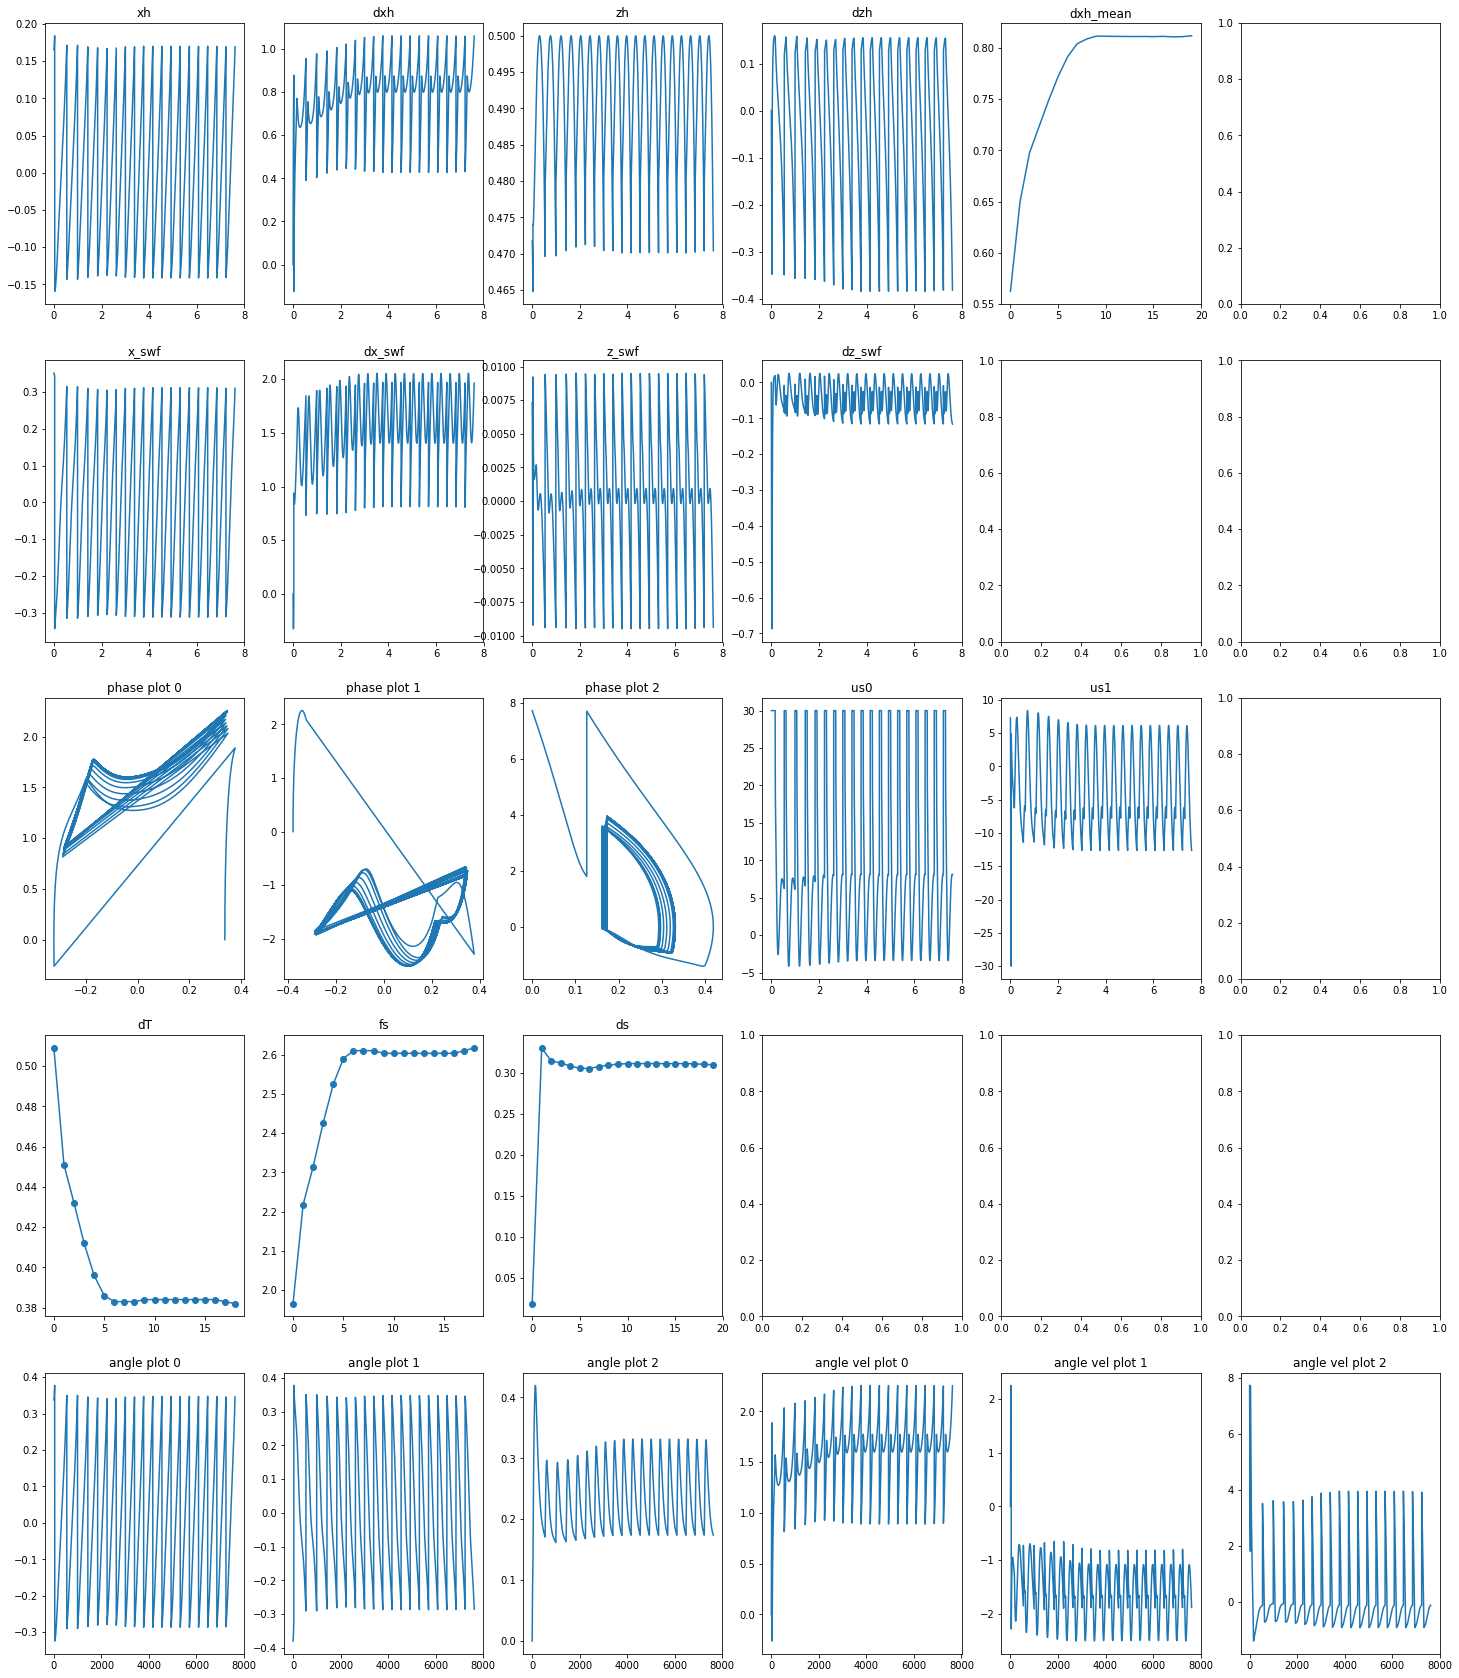

In [9]:
#extract the optimization result
q0, dq0, params = opt_params[:3], opt_params[3:6], opt_params[6:]

#run simulation using the optimized parameters
biped.set_control()
sln = biped.solve_eqns(q0, dq0, 20, params);

%matplotlib qt
#biped.animate(sln)

%matplotlib inline
ress = biped.analyse(sln, params, True)

#### Save the params

#### Load the params

#### Collect the resulting initial and final configs (to obtain the steady state part)

COT: 1601.82, Dist: 0.312, dT: 0.384


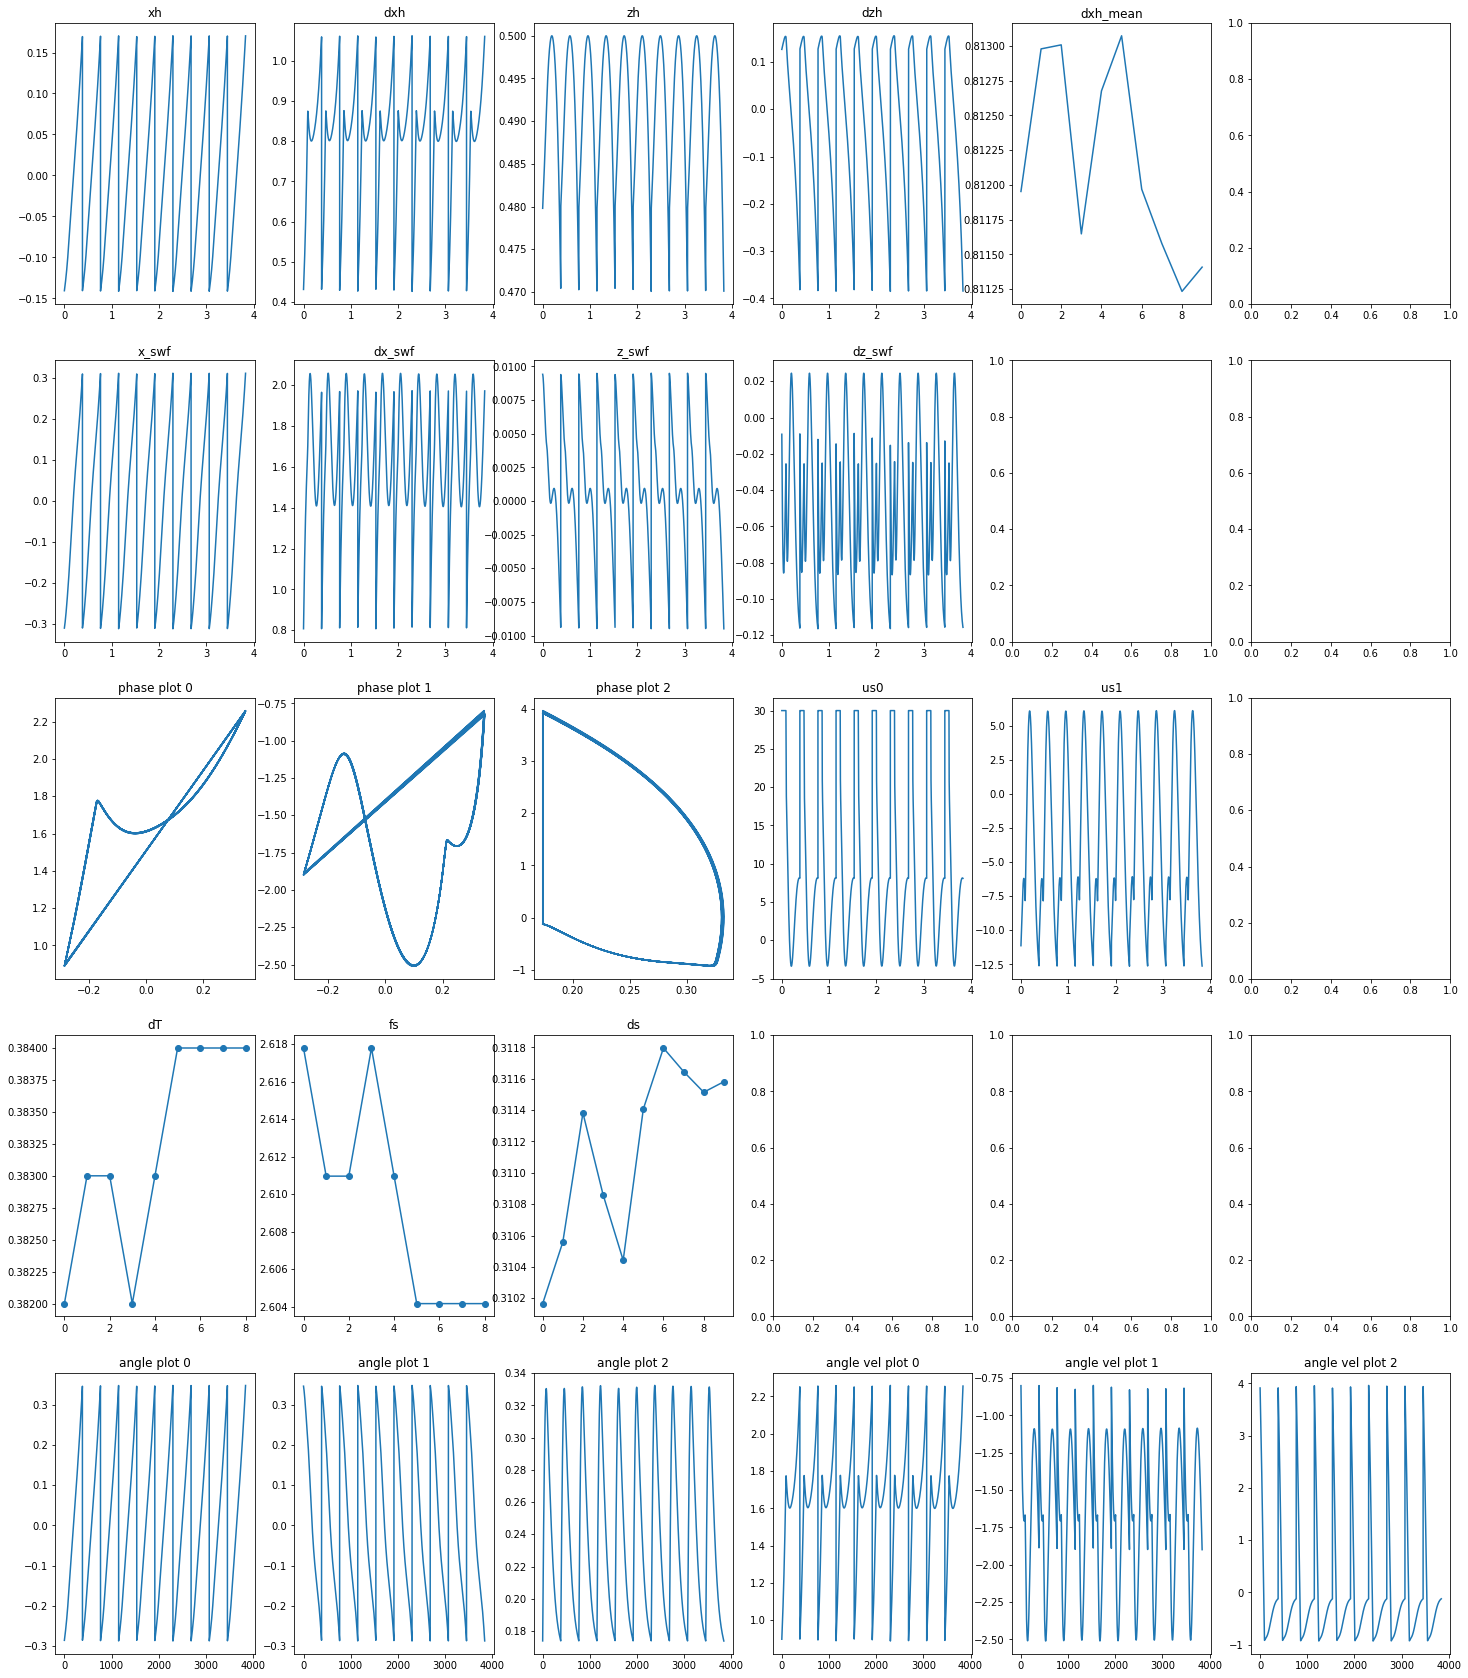

In [10]:
from utils import extract_init_goal

y0, yT = extract_init_goal(sln)
q0, dq0 = y0[-1,:3], y0[-1,3:]
qT, dqT = yT[-1,:3], yT[-1,3:]
T = sln['T'][-1][-1] - sln['T'][-1][0]
T = int(T/biped.dT)

biped.set_control()
sln = biped.solve_eqns(q0, dq0, 10, params)
clear_output()

res = biped.analyse(sln, params, to_plot=True)

In [11]:
np.concatenate([q0, dq0, params])

array([ -0.2853,   0.3459,   0.1738,   0.8984,  -0.8001,   3.9114,
       477.4578, 174.514 ,  73.1452,   5.5947,   0.138 ])

## Part 2: Using iLQR

### Formulate the iLQR problem

In [12]:
print(q0)
#q0[2] = 0.05
x0 = np.concatenate([q0, dq0])
xT = np.concatenate([qT, dqT])

Tc = T #375
x_ref = xT.copy()
#x_ref[2] = 0.05
biped.set_init_state(x0)

[-0.2853  0.3459  0.1738]


#### Define cost

In [13]:
u_max = 30
step_length = res['x_swf'][-1]

#standard cost on state and control
Q = np.diag([0,0,100,0,0,0])
Qf = np.diag([0,0,100,0,0,0])
R = np.eye(biped.Du)*.01

#swing trajectory
Wt = np.diag([0, 1e4])
z_refs = np.linspace(0.005, -0.01, Tc)

#swing foot final position
WT = np.diag([1e4, 1e5])*1
p_ref = np.array([step_length, -0.01])

costs = []
for i in range(Tc):
    if i < Tc/12:
        runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
    else:
        runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
        
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    
    if i > Tc/12:
        runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    else:
        runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)
        
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
    
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
costs += [terminalCost]

#for crocoddyl
#### Setup crocoddyl model
rmodels = []
for i in range(Tc):
    state = crocoddyl.StateVector(biped.Dx)
    rmodel = ActionModelRobot(state, biped.Du)
    rmodel.init_robot_sys(biped, nr = biped.Dx)
    rmodel.set_cost(costs[i])
    rmodel.u_lb = np.array([-u_max, -u_max])
    rmodel.u_ub = np.array([u_max,u_max])
    rmodels += [rmodel]

rmodel_T = ActionModelRobot(state, biped.Du)
rmodel_T.init_robot_sys(biped, nr = biped.Dx)
rmodel_T.set_cost(terminalCost)
rmodel_T.u_lb = np.array([-u_max, -u_max])
rmodel_T.u_ub = np.array([u_max,u_max])

problem = crocoddyl.ShootingProblem(x0, rmodels, rmodel_T)

#### Initialization

In [14]:
xs_init = np.array([x0]*(Tc+1))
us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((Tc+1, 3))))
biped.set_init_state(x0)

#### Solve

In [15]:
ddp = crocoddyl.SolverBoxFDDP(problem)

ddp.th_grad = 1e-6
ddp.th_stop = 1e-6
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)

xs_ref, us_ref = np.array(ddp.xs), np.array(ddp.us)
effort_ilqr = np.sum(us_ref[:,0]**2 + us_ref[:,1]**2)/(2*T*biped.dT*30)

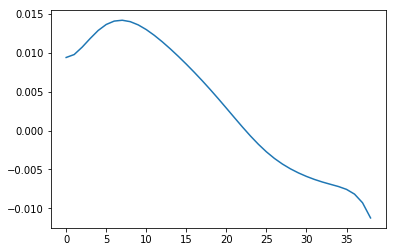

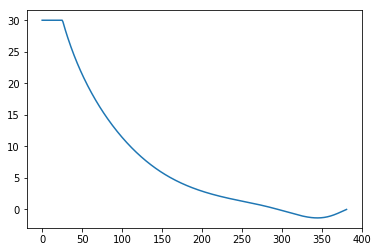

In [16]:
%matplotlib qt
z_swfs = biped.animate_ys(xs_ref)
%matplotlib inline
plt.plot(z_swfs)   
plt.figure()
plt.plot(us_ref[:,0])

#### Try simulation with ilqr

In [17]:
biped.set_control('ilqr', ddp)

In [18]:
sln = biped.solve_eqns(q0, dq0,10, biped.control_parameters)
clear_output()

COT: 7957.74, Dist: 0.028, dT: 0.023


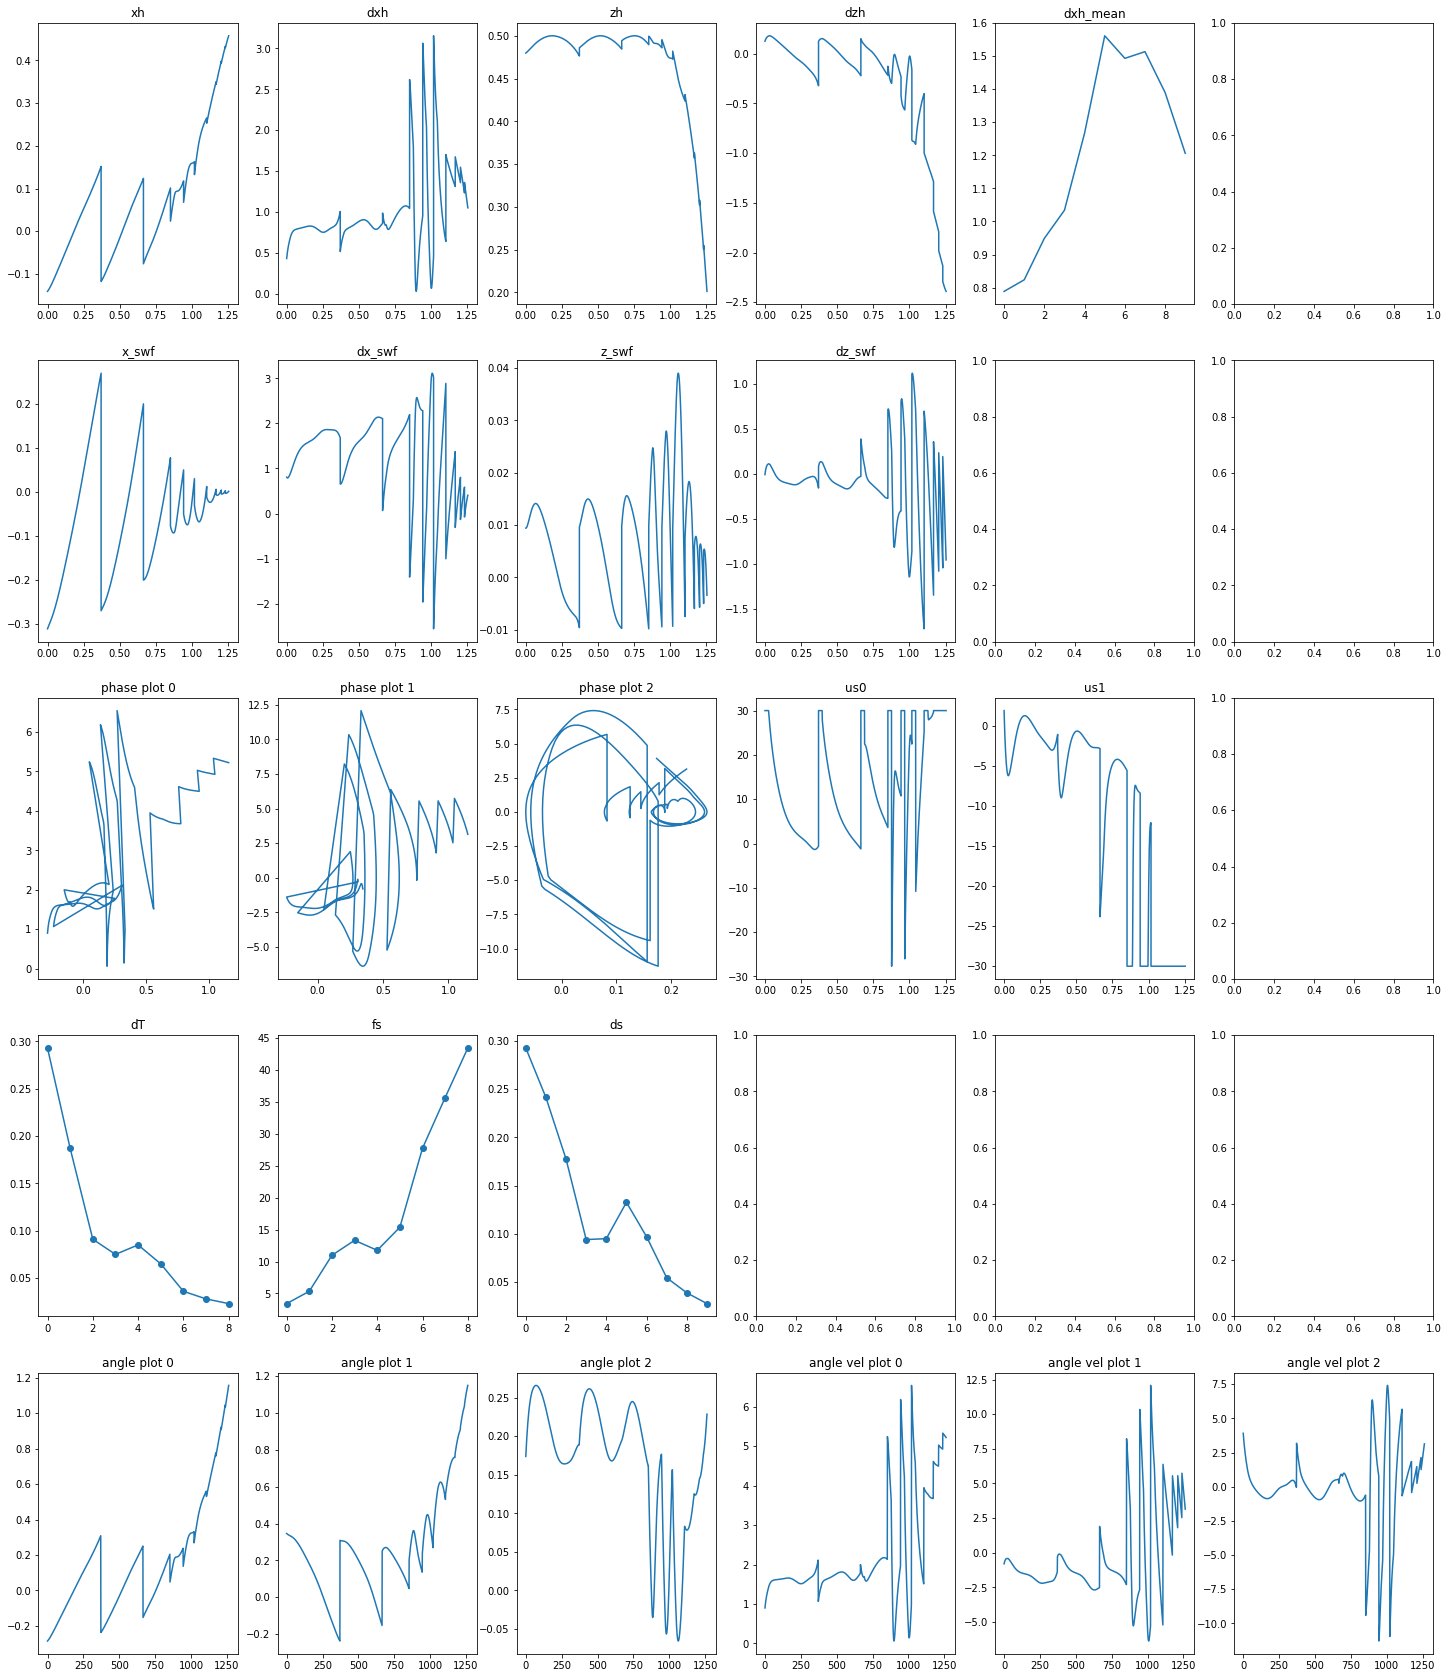

In [19]:
%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, True)

## Optimizing ILQR

In [20]:
def opt_func_ilqr(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    y0 = np.concatenate([q0, dq0])
    #Tc = opt_parameters[6]
    alpha = opt_parameters[6]
    step_length = opt_parameters[7]

    
    #define ilqr
    x_ref = np.array([0,0,alpha,0,0,0])
    biped.set_init_state(y0.copy())

    u_max = 30

    Q = np.diag([0,0,100,0,0,0])
    Qf = np.diag([0,0,100,0,0,0])
    R = np.eye(biped.Du)*.01

    #swing trajectory
    Wt = np.diag([0, 1e4])
    z_refs = np.linspace(0.005, -0.005, Tc)

    #swing foot final position
    WT = np.diag([1e4, 1e5])*1
    p_ref = np.array([step_length, -0.01])

    costs = []
    for i in range(Tc):
        if i < Tc/12:
            runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
        else:
            runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)

        runningControlCostShort = CostModelQuadratic(biped, None, R)
        p_ref_t = np.array([0, z_refs[i]])

        if i > Tc/12:
            runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
        else:
            runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)

        runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
        costs += [runningCostShort]

    terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
    terminalControlCost = CostModelQuadratic(biped, None,R)
    # terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
    terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
    terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
    costs += [terminalCost]

    #for crocoddyl
    #### Setup crocoddyl model
    rmodels = []
    for i in range(Tc):
        state = crocoddyl.StateVector(biped.Dx)
        rmodel = ActionModelRobot(state, biped.Du)
        rmodel.init_robot_sys(biped, nr = biped.Dx)
        rmodel.set_cost(costs[i])
        rmodel.u_lb = np.array([-u_max, -u_max])
        rmodel.u_ub = np.array([u_max,u_max])
        rmodels += [rmodel]

    rmodel_T = ActionModelRobot(state, biped.Du)
    rmodel_T.init_robot_sys(biped, nr = biped.Dx)
    rmodel_T.set_cost(terminalCost)
    rmodel_T.u_lb = np.array([-u_max, -u_max])
    rmodel_T.u_ub = np.array([u_max,u_max])

    problem = crocoddyl.ShootingProblem(y0, rmodels, rmodel_T)
    ddp = crocoddyl.SolverBoxFDDP(problem)

    ddp.th_grad = 1e-6
    ddp.th_stop = 1e-6
    ddp.setCallbacks([crocoddyl.CallbackVerbose()])
    
    
    #train ilqr
    xs_init = np.array([y0]*(ddp.problem.T+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((ddp.problem.T+1, 3))))
     
    ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)
    
        

    biped.set_control('ilqr', ddp)

    
    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    max_actuation = 30;
    effort = results['effort']
    distance = np.sum(results['ds'])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    print('cot:{}'.format(CoT))
    
    y0T = sln['Y'][-1][0]
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]
    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0T)
    w1 = 10
    w2 = 0.001
    vd = 0.9
    
    step_length = (results['ds'])[-1]
    s_d = 0.4
    #objective_value = w1*abs(vd - velocity) + w2*CoT #- 0.3*distance
    #objective_value = w1*abs(s_d - step_length) + w2*CoT #- 0.3*distance
    
    #objective_value = w1*abs(velocity-vd) + w2*CoT
    #objective_value = -np.mean(results['ds'][-3:])
    print('Obj:{0:.3f}, vel:{1:.3f}, step length:{2:.3f}:'.format(objective_value, velocity, step_length))
    print('Params:', opt_parameters)
    print('y0T, yn', y0T, yn)
    return objective_value

In [21]:
opt_parameters0 = np.concatenate([q0, dq0, np.array([x_ref[2], step_length])])

#### Simulation using Optimized parameters

In [87]:
opt_params = res[0]

## Computing the Poincare Map Eigenvalue

In [63]:
opt_params = np.array([-0.3419,  0.3907,  0.3515,  0.7878, -1.4536,  5.4395,  0.3432,
        0.3576])
Tc = 421
q0, dq0 = opt_params[:3], opt_params[3:6]
params = opt_params[6:]

In [64]:
opt_func_ilqr(opt_params, 1)

COT: 14545.02, Dist: 0.361, dT: 0.411
cot:14545.0151966
Obj:0.561, vel:0.879, step length:0.361:
('Params:', array([-0.3419,  0.3907,  0.3515,  0.7878, -1.4536,  5.4395,  0.3432,
        0.3576]))
('y0T, yn', array([-0.3419,  0.3907,  0.3515,  0.7878, -1.4536,  5.4395]), array([-0.3473,  0.3972,  0.3899,  0.7007, -1.5374,  5.9857]))


0.5607474962593255

In [65]:
x = np.concatenate([q0, dq0])

COT: 163.75, Dist: 0.363, dT: 0.415


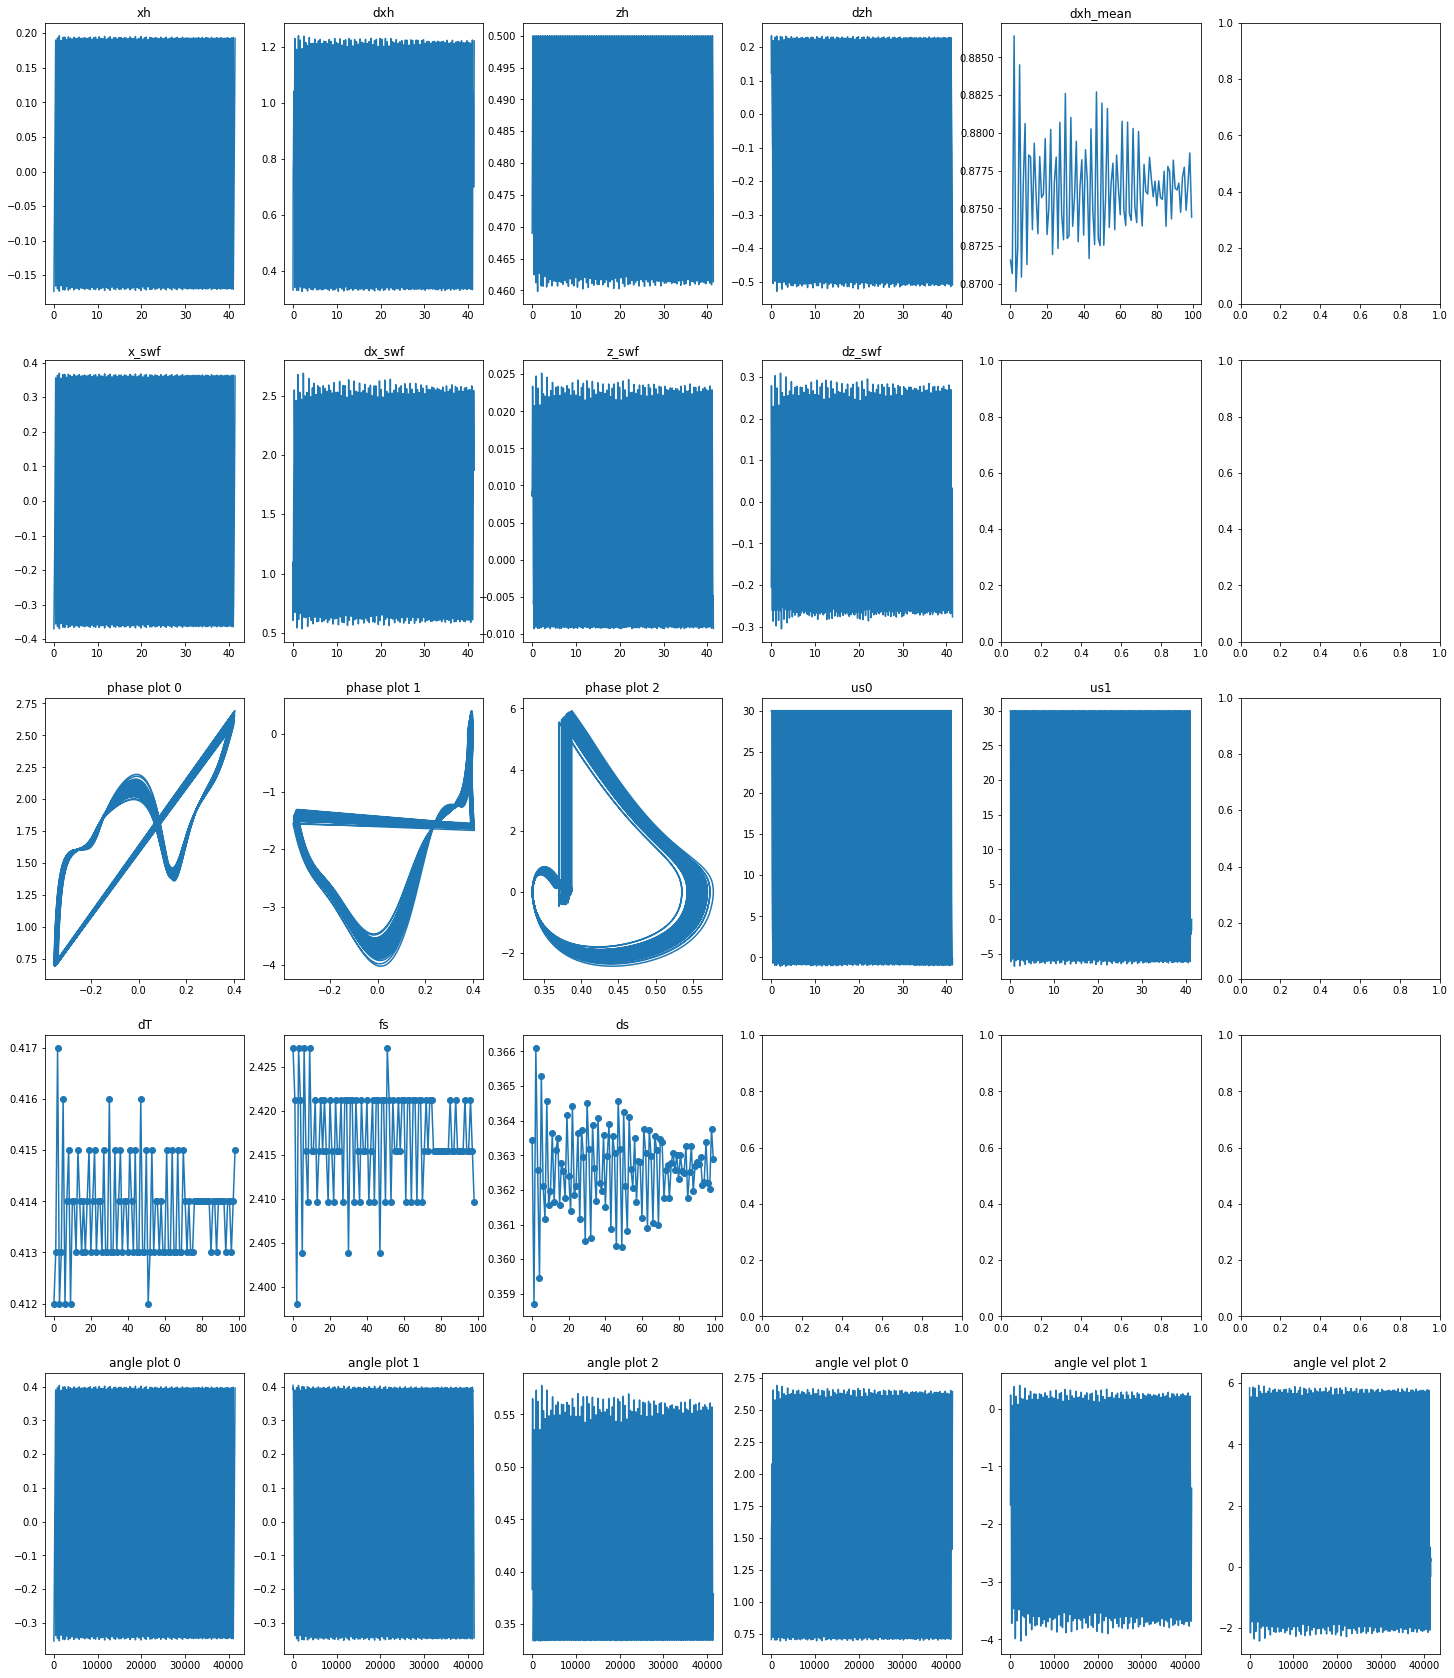

In [73]:
sln = biped.solve_eqns(x[:3], x[3:], 100, params)
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)

In [81]:
x = sln['Y'][-1][0]

In [82]:
print(x)

[-0.3473  0.3981  0.3796  0.7051 -1.6188  5.7749]


In [47]:
def calc_max_eig(eigs):
    eigs_norm = [np.linalg.norm(eig) for eig in eigs]
    return np.max(eigs_norm)

In [54]:
eigs = np.linalg.eigvals(J)
calc_max_eig(eigs)

0.9556238103648966

## Define Noise

In [94]:
x = sln['Y'][-1][0]

#### Simulate

COT: 701.21, Dist: 0.097, dT: 0.319


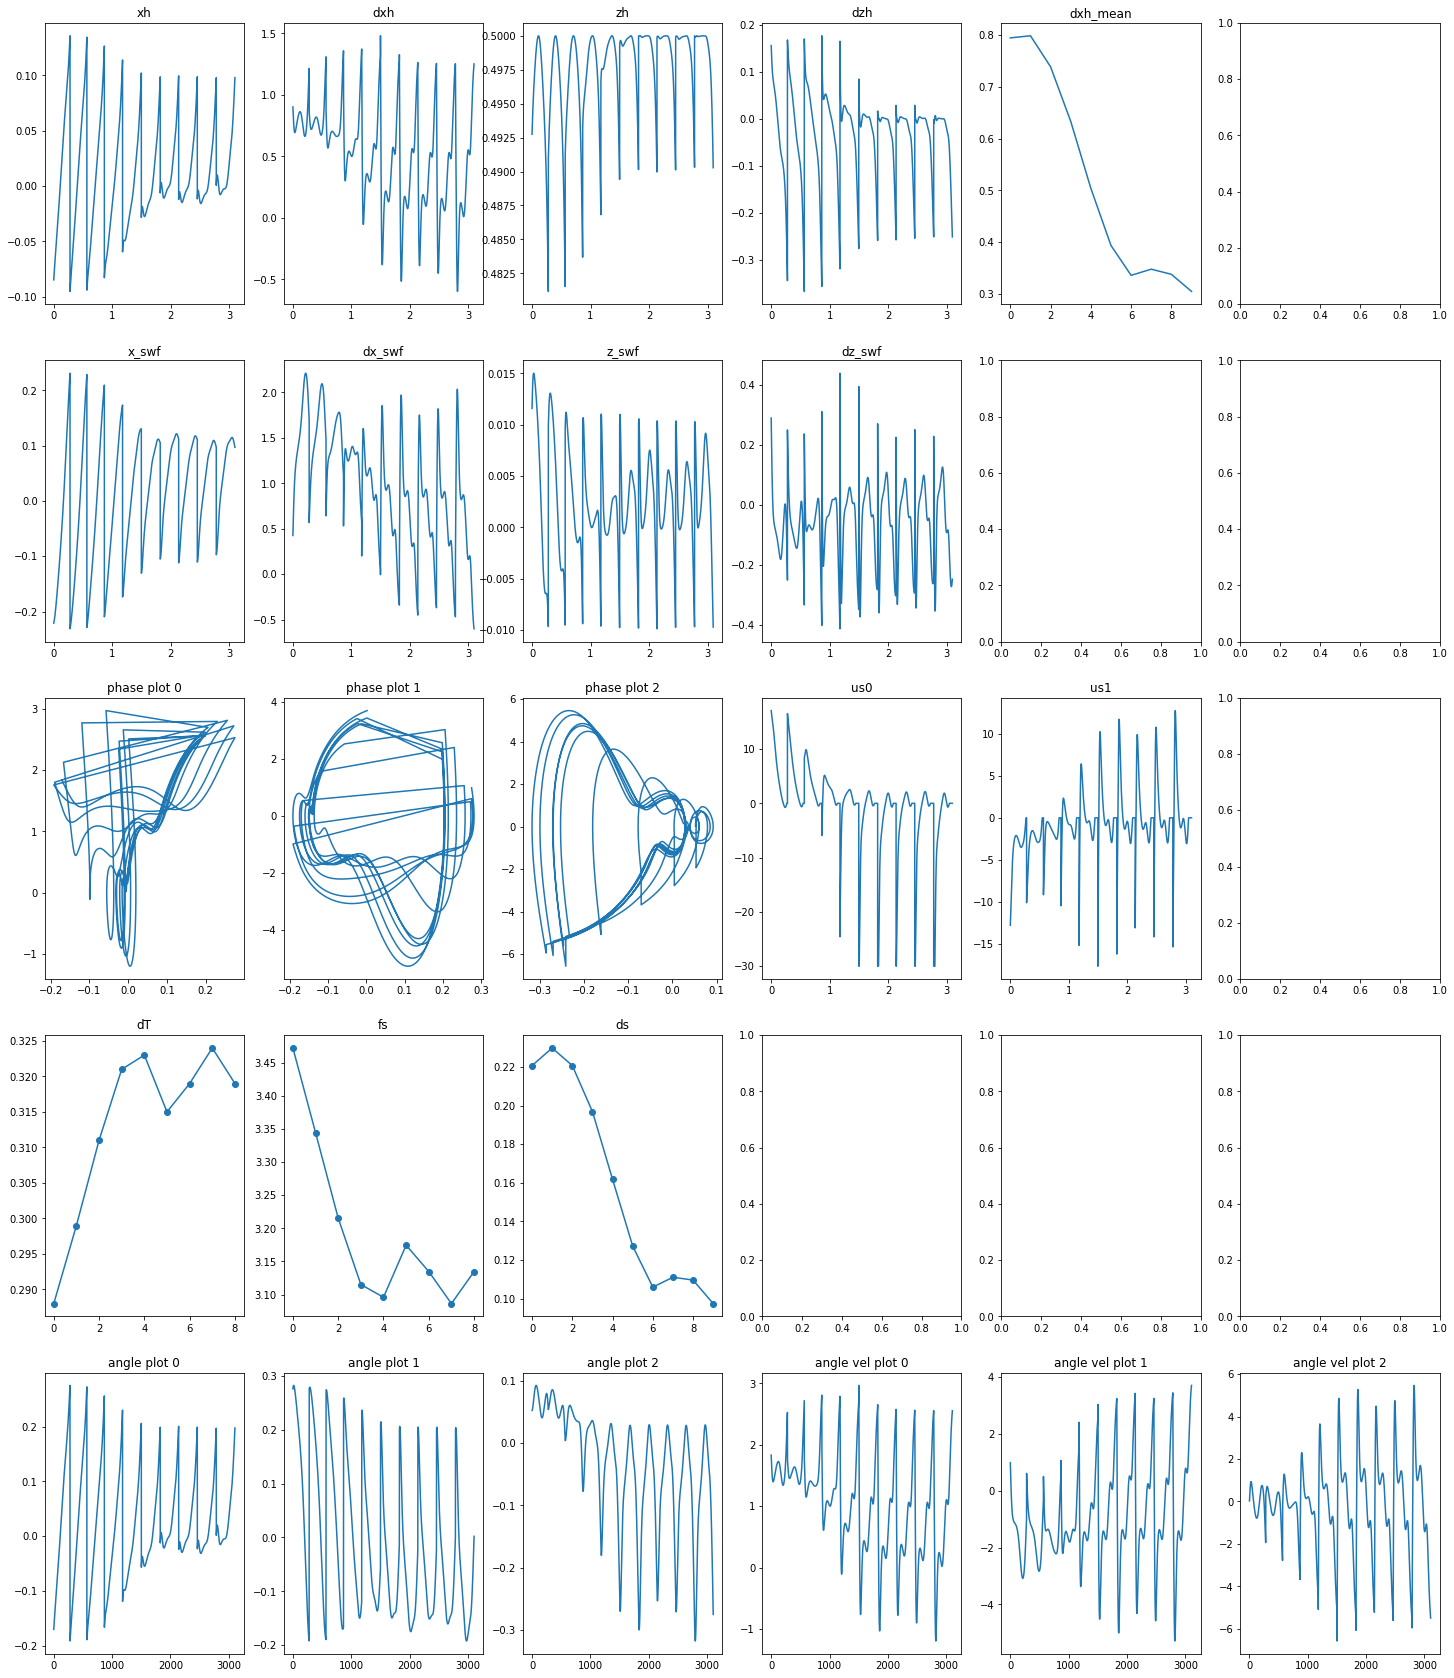

In [56]:
#opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 10, params)
%matplotlib qt
clear_output()
#biped.animate(sln)
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)
#plt.savefig('figures/example_v09.png', dpi = 500)

In [89]:
opt_params

array([-0.2747,  0.3187,  0.1915,  0.7745, -0.8736,  4.0491,  0.1886,
        0.3015])

In [90]:
Tc


382

#### Load Data

In [100]:
ilqr_data = np.load('ilqr_params/f365.npy', allow_pickle=True)[()]

In [106]:
opt_params = ilqr_data['opt_params']

In [37]:
opt_params = np.array([-0.3419,  0.3907,  0.3515,  0.7878, -1.4536,  5.4395,  0.3432, 0.3576])
T = 421


Tc = T

#### Save Data

In [ ]:
%matplotlib qt
biped.animate(sln)

****

## Try QP

In [444]:
biped.ilqr = ddp

In [ ]:
xs_ilqr = sln['Y'][-1]
ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis=0))[:,3:]*1000

In [508]:
Kp = np.diag(np.array([2000,3000,4000]))
Kd = np.diag(np.array([1000,100,100]))
#Kp = np.diag(np.array([4000,500,4000]))
# Kd = np.diag(np.array([1500,100,100]))
# Kp = np.diag(np.array([100000,2000,100000]))
# Kd = np.diag(np.array([2000,2000,100]))

Q = np.diag(np.array([100,100,100]))
biped.set_control('qp', biped.ilqr, xs_ilqr, ddqs_ilqr,  Q = Q, Kd = Kd, Kp = Kp, max_control=30)

#### Simulation using Optimized parameters

In [512]:
xs_qp = sln['Y'][0]

ddqs_qp = np.array(np.gradient(xs_qp, axis=0))[:,3:]*1000

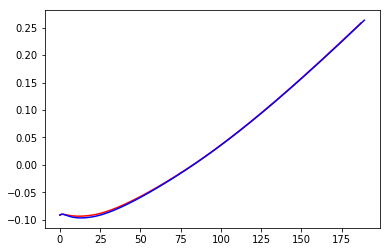

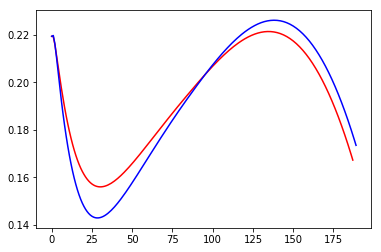

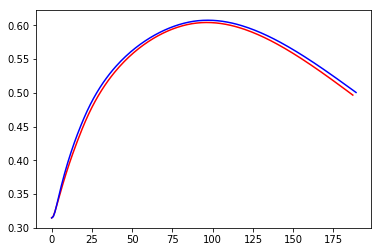

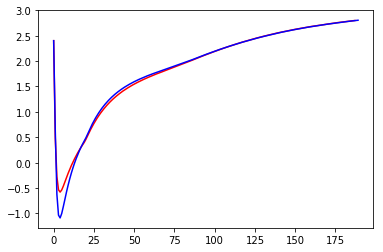

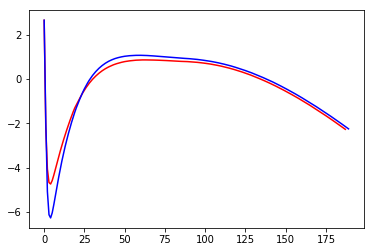

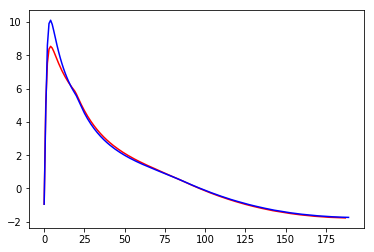

In [513]:
%matplotlib inline
for idx in range(6):
    plt.figure()
    plt.plot(xs_ilqr[:,idx], 'r')
    plt.plot(xs_qp[:,idx], 'b')


In [509]:
q0,dq0 = xs_ilqr[0,:3], xs_ilqr[0,3:]

In [510]:
# opt_params = res[0]
# q0 = opt_params[:3]
# dq0 = opt_params[3:6]
# params = opt_params[6:]
# params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 3, None)
%matplotlib qt
clear_output()
#biped.animate(sln)

COT: 276655.19, Dist: 0.088, dT: 0.074


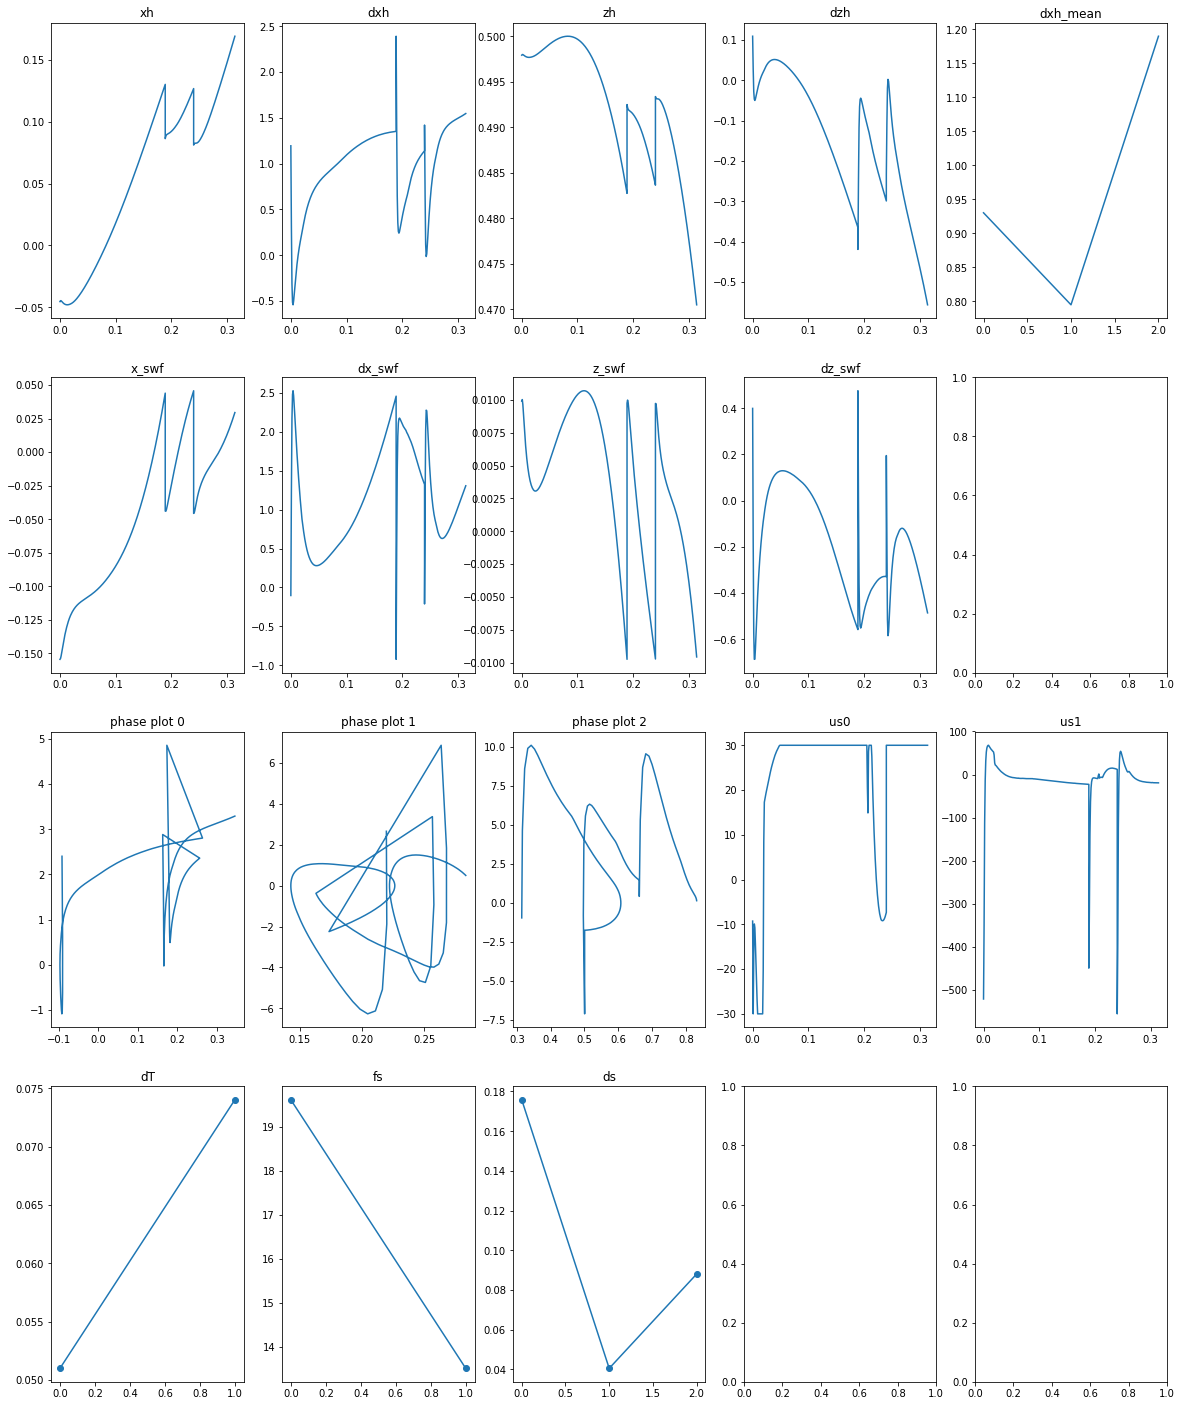

In [511]:
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)
plt.savefig('d.png')